# Python script for a spatial explorations of the EDH dataset
*Created by: Vojtech Kase*


Requirements:
*   Access to Sciencedata.dk or access alternatively to the dataset in JSON
*   `libspatialindex` C library for spatial indexing, which is a prerequisite for `rtree`
*   Basic knowledge of Python (how to run scripts in Python notebooks)



# Requirements

In [36]:
### GENERAL REQUIREMENTS - will install the libraries
import numpy as np
import math
import pandas as pd
import sys
import requests
from urllib.request import urlopen 
from bs4 import BeautifulSoup
import io
import os
import time # to avoid errors, we sometime use time.sleep(N) before retrying a request
import json # the input data have typically a json structure
import getpass
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import warnings
warnings.filterwarnings('ignore')

import sddk

There is a number of additional packages for working with spatial data, which require individual installation

some advanced spatial indexing requires libspatialindex library based on C

libspatialindex is used by Rtree

you further need contextily (>=1.0rc2), shapely, geopandas (==0.6.2 or >=0.6.4 - 0.6.3 does not work properly), pyshp

and for nicely looking colormaps, you might also need:
```
#!pip install pysal # to parametrize colorscale maps, it is somehow above mapclassify
#import pysal 
#!pip install mapclassify # to parametrize colorscale maps
#import mapclassify
```

In [3]:
from rtree import index
from rtree.index import Rtree

In [4]:
import contextily as ctx
import shapely
import geopandas
import shapefile
import mapclassify

## Establish connection with sciencedata.dk: configure session and shared folder URL

In [40]:
### configure session and groupurl
### in the case of "SDAM_root", the folder owner is Vojtech with username 648597@au.dk
conf = sddk.configure_session_and_url("SDAM_root", "648597@au.dk")

sciencedata.dk username (format '123456@au.dk'): 648597@au.dk
sciencedata.dk password: ········
connection with shared folder established with you as its owner
endpoint variable has been configured to: https://sciencedata.dk/files/SDAM_root/


# Reading Roman provinces data from shapefiles located on web

there is a lot of relevant shapefiles dispersed through the internet. For political borders of the Roman Empire, see [this](http://awmc.unc.edu/awmc/map_data/shapefiles/cultural_data/political_shading/). Check also this link for many other interesting datasets: https://projectmercury.eu/datasets/.

Unfortunately, I (Vojtech) still cannot find a database with Roman provinces including names of the provinces. Perhaps I just do not know where to look for it.

In [5]:
### (1) READ THE SHAPEFILE INTO A READER OBJECT

### here we rely on pyshp (or "shapefile") and its Reader() function
### to properly read a shapefile, you need access at least to the ".shp" file and the ".dbf" file
url_raw_filename = "http://awmc.unc.edu/awmc/map_data/shapefiles/cultural_data/political_shading/roman_empire_ad_117/shape/roman_empire_ad_117"
file_shp = urlopen(url_raw_filename + ".shp")
file_dbf = urlopen(url_raw_filename + ".dbf")
reader = shapefile.Reader(shp=file_shp, dbf=file_dbf) ### see https://pypi.org/project/pyshp/#reading-shapefiles-from-file-like-objects
### now we have a reader object to iterate over
len(reader.records())

111

In [6]:
### (2) GENERATE A GEODATAFRAME FROM THE READER OBJECT

### based on https://gist.github.com/frankrowe/6071443
features = []
field_names = [field[0] for field in reader.fields[1:]]
for element in reader.shapeRecords():
  atr = dict(zip(field_names, element.record))
  geo = element.shape.__geo_interface__
  features.append(dict(type="Feature", geometry=geo, properties=atr))

provinces = geopandas.GeoDataFrame.from_features(features)
provinces.head()

,geometry,OBJECTID,AREA,PERIMETER,NEWDIO_,NEWDIO_ID,ID,Shape_Leng,Shape_Area
0,"POLYGON ((-1.57431 55.16792, -1.50632 54.98433...",1,19.612703,35.387086,2,0,0,35.115167,19.325197
1,"POLYGON ((-4.59302 54.30514, -4.56152 54.34428...",2,0.080670,1.212228,3,0,0,1.212228,0.080670
2,"POLYGON ((-0.57376 53.75199, -0.60391 53.70755...",3,0.006408,0.311314,4,0,0,0.311314,0.006408
3,"POLYGON ((-4.60976 53.31895, -4.57282 53.35276...",4,0.092548,1.281687,5,0,0,1.281687,0.092548
4,"POLYGON ((1.68338 52.73775, 1.75385 52.69902, ...",5,0.005562,0.312915,6,0,0,0.312915,0.005562


<AxesSubplot:>

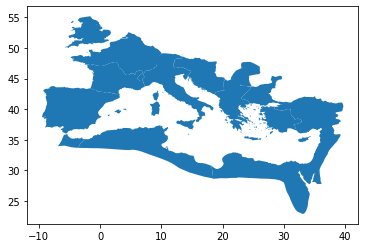

In [7]:
provinces.plot()

## EDH dataset from sciencedata.dk


In [8]:
### Once the connection has been succesfuilly established, we can upload the data from sciencedata into Pandas dataframe
### Look at Pandas documention to learn how to navigate Pandas dataframe with their endless functionality: https://pandas.pydata.org/pandas-docs/version/0.23.4/index.html
publicfolder = "b6b6afdb969d378b70929e86e58ad975"
EDH_df = sddk.read_file("EDH_attrs_cleaned_2020-09-28.json", "df", publicfolder)
EDH_df.head(5)
EDH_df.head(5) ### use ".head(5)" to inspect first 5 rows of the dataframe

reading file located in a public folder


,responsible_individual,type_of_inscription,letter_size,not_after,literature,work_status,height,diplomatic_text,people,depth,...,country_certainty,findspot_ancient_clean,findspot_ancient_certainty,modern_region_clean,modern_region_certainty,findspot_modern_clean,findspot_modern_certainty,findspot_clean,findspot_certainty,origdate_text_clean
0,Feraudi,epitaph,3.2-2 cm,0130,"AE 1983, 0192.; M. Annecchino, Puteoli 4/5, 19...",provisional,33 cm,D M / NONIAE P F OPTATAE / ET C IVLIO ARTEMONI...,"[{'name': 'Noniae P.f. Optatae', 'cognomen': '...",2.7 cm,...,Certain,Cumae,Estimated,Campania,Certain,"Cuma, bei",Certain,NULL,NULL,71 AD – 130 AD
1,Feraudi,epitaph,4 cm,0200,"AE 1983, 0080. (A); A. Ferrua, RAL 36, 1981, 1...",no image,28 cm,C SEXTIVS PARIS / QVI VIXIT / ANNIS LXX,"[{'nomen': 'Sextius', 'praenomen': 'C.', 'pers...",{},...,Certain,Roma,Certain,Lazio,Certain,Roma,Certain,"Via Nomentana, S. Alessandro, Kirche",Certain,51 AD – 200 AD
2,Feraudi,honorific inscription,4.5-3 cm,0170,"AE 1983, 0518. (B); J. González, ZPE 52, 1983,...",provisional,(37) cm,[ ]VMMIO [ ] / [ ]ISENNA[ ] / [ ] XV[ ] / [ ] / [,"[{'nomen': 'Mummius+', 'gender': 'male', 'prae...",(12) cm,...,Certain,NULL,NULL,Sevilla,Certain,Tomares,Certain,NULL,NULL,131 AD – 170 AD
3,Gräf,votive inscription,2.5 cm,0200,"AE 1983, 0533. (B); A.U. Stylow, Gerión 1, 198...",checked with photo,(39) cm,[ ]AVS[ ]LLA / M PORCI NIGRI SER / DOMINAE VEN...,[{'name': '[---?]AV(?)S(?)[---]L(?)L(?)A M. Po...,18 cm,...,Certain,Ipolcobulcula,Certain,Córdoba,Certain,Carcabuey,Certain,NULL,NULL,151 AD – 200 AD
4,Feraudi,epitaph,{},0200,"AE 1983, 0078. (B); A. Ferrua, RAL 36, 1981, 1...",no image,{},[ ] L SVCCESSVS / [ ] L L IRENAEVS / [ ] C L T...,"[{'person_id': '1', 'name': '[---]l. Successus...",{},...,Certain,Roma,Certain,Lazio,Certain,Roma,Certain,Via Cupa (ehem. Vigna Nardi),Certain,1 AD – 200 AD


# EDH as GeoDataframe

In [9]:
# where are the coordinates?
EDH_df.columns

Index(['responsible_individual', 'type_of_inscription', 'letter_size',
       'not_after', 'literature', 'work_status', 'height', 'diplomatic_text',
       'people', 'depth', 'material', 'type_of_monument', 'province_label',
       'width', 'transcription', 'country', 'uri', 'findspot_ancient',
       'last_update', 'modern_region', 'findspot_modern', 'language', 'id',
       'edh_geography_uri', 'commentary', 'trismegistos_uri', 'not_before',
       'findspot', 'year_of_find', 'present_location', 'external_image_uris',
       'religion', 'fotos', 'geography', 'social_economic_legal_history',
       'military', 'coordinates', 'idno_tm', 'placenames_refs', 'text_edition',
       'origdate_text', 'layout_execution', 'layout_execution_text',
       'support_objecttype', 'support_objecttype_text', 'support_material',
       'support_material_text', 'support_decoration', 'keywords_term',
       'keywords_term_text', 'type_of_inscription_clean',
       'type_of_inscription_certainty', 'heigh

In [10]:
# 
EDH_df["coordinates"].tolist()[:10]

[[14.0551, 40.8472],
 [12.4823, 41.8955],
 [-6.0459, 37.3728],
 [-4.2747, 37.4442],
 [12.4823, 41.8955],
 [-5.0244, 36.9515],
 [12.4823, 41.8955],
 [12.4823, 41.8955],
 [-2.3598, 51.3811],
 [12.5632, 44.059]]

In [11]:
### make GeoDataFrame geometry
def set_coordinate(row, i):
    try:
        coor = float(row["coordinates"][i])
    except:
        coor = None
    return coor
EDH_df["x"] = EDH_df.apply(lambda row: set_coordinate(row, 0), axis=1)
EDH_df["y"] = EDH_df.apply(lambda row: set_coordinate(row, 1), axis=1)
EDH_gdf = geopandas.GeoDataFrame(EDH_df, geometry = geopandas.points_from_xy(x=EDH_df["x"], y=EDH_df["y"]))
EDH_gdf.drop(columns=["coordinates", "x", "y"], inplace=True)
EDH_gdf.head(5)

,responsible_individual,type_of_inscription,letter_size,not_after,literature,work_status,height,diplomatic_text,people,depth,...,findspot_ancient_clean,findspot_ancient_certainty,modern_region_clean,modern_region_certainty,findspot_modern_clean,findspot_modern_certainty,findspot_clean,findspot_certainty,origdate_text_clean,geometry
0,Feraudi,epitaph,3.2-2 cm,0130,"AE 1983, 0192.; M. Annecchino, Puteoli 4/5, 19...",provisional,33 cm,D M / NONIAE P F OPTATAE / ET C IVLIO ARTEMONI...,"[{'name': 'Noniae P.f. Optatae', 'cognomen': '...",2.7 cm,...,Cumae,Estimated,Campania,Certain,"Cuma, bei",Certain,NULL,NULL,71 AD – 130 AD,POINT (14.05510 40.84720)
1,Feraudi,epitaph,4 cm,0200,"AE 1983, 0080. (A); A. Ferrua, RAL 36, 1981, 1...",no image,28 cm,C SEXTIVS PARIS / QVI VIXIT / ANNIS LXX,"[{'nomen': 'Sextius', 'praenomen': 'C.', 'pers...",{},...,Roma,Certain,Lazio,Certain,Roma,Certain,"Via Nomentana, S. Alessandro, Kirche",Certain,51 AD – 200 AD,POINT (12.48230 41.89550)
2,Feraudi,honorific inscription,4.5-3 cm,0170,"AE 1983, 0518. (B); J. González, ZPE 52, 1983,...",provisional,(37) cm,[ ]VMMIO [ ] / [ ]ISENNA[ ] / [ ] XV[ ] / [ ] / [,"[{'nomen': 'Mummius+', 'gender': 'male', 'prae...",(12) cm,...,NULL,NULL,Sevilla,Certain,Tomares,Certain,NULL,NULL,131 AD – 170 AD,POINT (-6.04590 37.37280)
3,Gräf,votive inscription,2.5 cm,0200,"AE 1983, 0533. (B); A.U. Stylow, Gerión 1, 198...",checked with photo,(39) cm,[ ]AVS[ ]LLA / M PORCI NIGRI SER / DOMINAE VEN...,[{'name': '[---?]AV(?)S(?)[---]L(?)L(?)A M. Po...,18 cm,...,Ipolcobulcula,Certain,Córdoba,Certain,Carcabuey,Certain,NULL,NULL,151 AD – 200 AD,POINT (-4.27470 37.44420)
4,Feraudi,epitaph,{},0200,"AE 1983, 0078. (B); A. Ferrua, RAL 36, 1981, 1...",no image,{},[ ] L SVCCESSVS / [ ] L L IRENAEVS / [ ] C L T...,"[{'person_id': '1', 'name': '[---]l. Successus...",{},...,Roma,Certain,Lazio,Certain,Roma,Certain,Via Cupa (ehem. Vigna Nardi),Certain,1 AD – 200 AD,POINT (12.48230 41.89550)


In [12]:
#del EDH_df

# Orbis Transportation Network (from online geojson)

In [13]:
### add orbis transportation network
url = "https://raw.githubusercontent.com/emeeks/orbis_v2/master/base_routes.geojson"
orbis = geopandas.read_file(url)
orbis.head()

,gid,sid,tid,t,e,s,geometry
0,559512,50001,50056,road,1.91,1.82,"LINESTRING (10.89500 48.36500, 10.89344 48.354..."
1,558621,50001,50100,road,1.75,1.67,"LINESTRING (10.32700 47.72700, 10.33948 47.738..."
2,559794,50001,50293,road,2.30,2.19,"LINESTRING (11.08600 47.49200, 11.10305 47.505..."
3,560116,50001,50473,road,7.89,7.51,"LINESTRING (11.17000 46.66000, 11.16163 46.679..."
4,558775,50002,50275,road,3.23,3.07,"LINESTRING (41.24466 37.07815, 41.27515 37.077..."


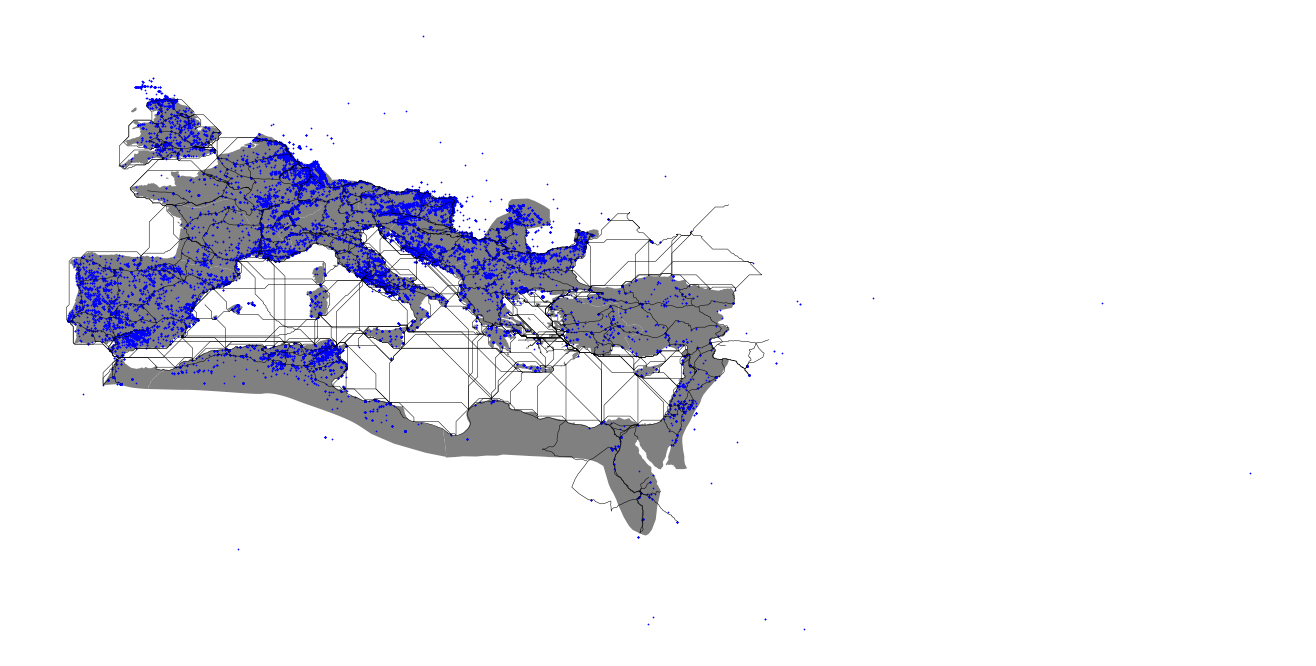

In [14]:
# Make a plot with basemap
plt.rcParams['figure.figsize'] = [24, 12]
fig, ax = plt.subplots()
provinces.plot(color="grey", ax=ax)
orbis.plot(color="black", linewidth=0.5 , ax=ax)
EDH_gdf.plot(markersize=0.5, color="blue", ax=ax) 
plt.axis("off")
plt.show()

# EDH + PROVINCES - Spatial Join

In [15]:
provinces.head(5)

,geometry,OBJECTID,AREA,PERIMETER,NEWDIO_,NEWDIO_ID,ID,Shape_Leng,Shape_Area
0,"POLYGON ((-1.57431 55.16792, -1.50632 54.98433...",1,19.612703,35.387086,2,0,0,35.115167,19.325197
1,"POLYGON ((-4.59302 54.30514, -4.56152 54.34428...",2,0.080670,1.212228,3,0,0,1.212228,0.080670
2,"POLYGON ((-0.57376 53.75199, -0.60391 53.70755...",3,0.006408,0.311314,4,0,0,0.311314,0.006408
3,"POLYGON ((-4.60976 53.31895, -4.57282 53.35276...",4,0.092548,1.281687,5,0,0,1.281687,0.092548
4,"POLYGON ((1.68338 52.73775, 1.75385 52.69902, ...",5,0.005562,0.312915,6,0,0,0.312915,0.005562


In [16]:
len(EDH_gdf)

81476

In [17]:
#### SELECT INSCIRPTIONS WITHIN PROVINCES

### geopandas.sjoin(df1, df2[[selected_col1, selected_col2]], op="within")
EDH_gdf = geopandas.sjoin(EDH_gdf, provinces[["geometry", "OBJECTID"]], op="within")

In [18]:
### now we have only inscriptions within provinces
len(EDH_gdf)

72608

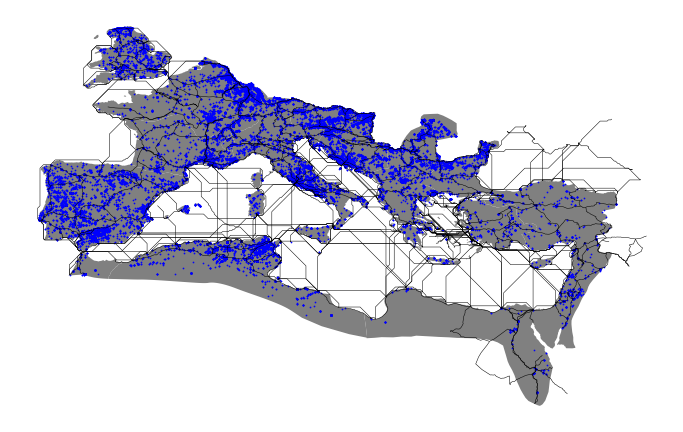

In [19]:
# Make a plot with basemap
plt.rcParams['figure.figsize'] = [12, 8]
fig, ax = plt.subplots()
provinces.plot(color="grey", ax=ax)
orbis.plot(color="black", linewidth=0.5 , ax=ax)
EDH_gdf.plot(markersize=0.5, color="blue", ax=ax) 
plt.axis("off")
plt.show()

# Distrubution of inscriptions per province

In [20]:
### DENSITY OF INSCRIPTIONS PER PROVINCE
def calculate_ins_density(row_objectid, filter_col=None, filter_value=None):
  try:
    if filter_value==None:
      ins_count = len(EDH_gdf[EDH_gdf["OBJECTID"]==row_objectid])
    else:
      EDH_filtered = EDH_gdf[EDH_gdf[filter_col].str.startswith(filter_value, na=False)]
      ins_count = len(EDH_filtered[EDH_filtered["OBJECTID"]==row_objectid])
  except:
    ins_count = 0
  try: 
    ins_dens = ins_count / provinces[provinces["OBJECTID"]==row_objectid]["AREA"].tolist()[0]
    ### ins_dens = math.log2(ins_dens) ### perhaps a logarithmized version could be more useful at some point
  except:
    ins_dens = 0
  return ins_dens

In [21]:
provinces["ins_dens"] = provinces.apply(lambda row: calculate_ins_density(row["OBJECTID"]), axis=1)

/home/kasev/.local/lib/python3.6/site-packages/mapclassify/classifiers.py:236: UserWarning: Warning: Not enough unique values in array to form k classes
  "Warning: Not enough unique values in array to form k classes", UserWarning
/home/kasev/.local/lib/python3.6/site-packages/mapclassify/classifiers.py:238: UserWarning: Warning: setting k to 11
  Warn("Warning: setting k to %d" % k_q, UserWarning)


(-11.947246500000166,
 42.171136499999456,
 21.281868500000837,
 56.78154149999981)

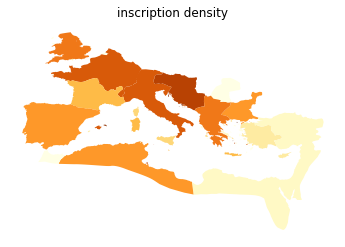

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

#vmax=provinces[provinces["ins_dens"] < provinces["ins_dens"].quantile(.98)]["ins_dens"].max() # max value without outliers
#vcenter=vmax/2
#divnorm = colors.DivergingNorm(vmin=0, vcenter=vcenter, vmax=vmax)
#cbar = plt.cm.ScalarMappable(norm=divnorm, cmap='RdBu')

provinces.plot(column="ins_dens", cmap='YlOrBr', scheme="quantiles", k=20, ax=ax) # add "norm=divnorm"
ax.set_title("inscription density")
ax.axis("off")

# Spatial distribution of different monument types

In [31]:
EDH_gdf.columns

Index(['responsible_individual', 'type_of_inscription', 'letter_size',
       'not_after', 'literature', 'work_status', 'height', 'diplomatic_text',
       'people', 'depth', 'material', 'type_of_monument', 'province_label',
       'width', 'transcription', 'country', 'uri', 'findspot_ancient',
       'last_update', 'modern_region', 'findspot_modern', 'language', 'id',
       'edh_geography_uri', 'commentary', 'trismegistos_uri', 'not_before',
       'findspot', 'year_of_find', 'present_location', 'external_image_uris',
       'religion', 'fotos', 'geography', 'social_economic_legal_history',
       'military', 'idno_tm', 'placenames_refs', 'text_edition',
       'origdate_text', 'layout_execution', 'layout_execution_text',
       'support_objecttype', 'support_objecttype_text', 'support_material',
       'support_material_text', 'support_decoration', 'keywords_term',
       'keywords_term_text', 'type_of_inscription_clean',
       'type_of_inscription_certainty', 'height_cm', 'width_c

In [32]:
EDH_gdf["type_of_monument_clean"].tolist()[:10]

['tabula',
 'tabula',
 'stele',
 'tabula',
 'tabula',
 'urn',
 'stele',
 'tabula',
 'tabula',
 'tabula']

In [33]:
### what types of monument we have and how many
mon_types_counts = []
for mon_type in EDH_gdf["type_of_monument_clean"].unique():
  if str(mon_type)[-1] != "?":
    mon_type_df = EDH_gdf[EDH_gdf["type_of_monument_clean"]==mon_type]
    mon_type_len = len(mon_type_df)
    mon_types_counts.append([mon_type, mon_type_len])
def getKey(item):
    return item[1]
mon_types_counts = sorted(mon_types_counts, key=getKey, reverse=True)
mon_types_counts

[['NULL', 23509],
 ['tabula', 11847],
 ['altar', 8761],
 ['stele', 8585],
 ['instrumentum domesticum', 3749],
 ['statue base', 2365],
 ['block', 2245],
 ['architectural member', 1815],
 ['sarcophagus', 1591],
 ['mile-/leaguestone', 1504],
 ['tile', 1270],
 ['urn', 584],
 ['base', 563],
 ['slab', 562],
 ['relief', 530],
 ['tessera', 506],
 ['instrumentum sacrum', 452],
 ['jewellery', 411],
 ['cippus', 325],
 ['cliff', 304],
 ['honorific/grave/votive column', 274],
 ['instrumentum militare', 162],
 ['statue', 149],
 ['grave monument', 146],
 ['bar', 63],
 ['weapon', 54],
 ['table', 50],
 ['herm', 45],
 ['cupa', 41],
 ['fountain', 30],
 ['diptych', 19],
 ['honorific/votive arch', 18],
 ['sculpture', 17],
 ['fortification', 16],
 ['paving stone', 15],
 ['bench', 11],
 ['bust', 10],
 ['shield', 7],
 ['olla', 3]]

In [37]:
### lwr 
mon_types_counts[1:10]

[['tabula', 11847],
 ['altar', 8761],
 ['stele', 8585],
 ['instrumentum domesticum', 3749],
 ['statue base', 2365],
 ['block', 2245],
 ['architectural member', 1815],
 ['sarcophagus', 1591],
 ['mile-/leaguestone', 1504]]

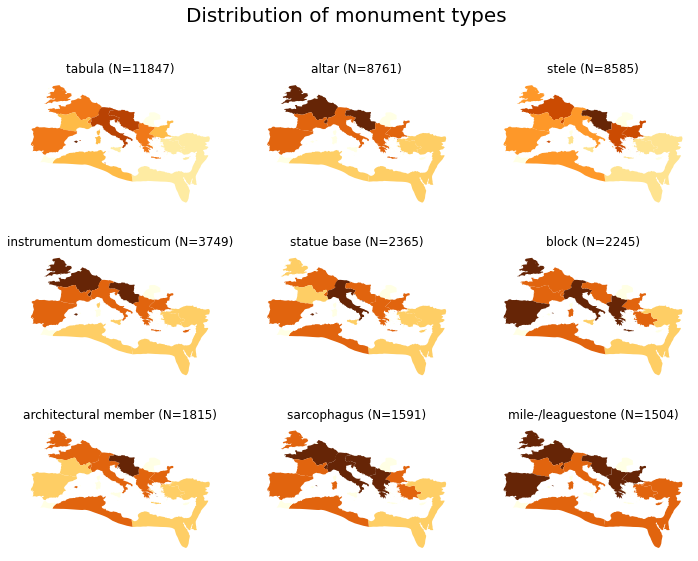

In [39]:
fig, axs = plt.subplots(3, 3, figsize=(12, 9))
for ax, mon_type in zip(axs.ravel(), mon_types_counts[1:10]):  
  provinces[mon_type[0] + "_dens"] = provinces.apply(lambda row: calculate_ins_density(row["OBJECTID"], "type_of_monument_clean", mon_type[0]), axis=1)
  provinces.plot(column=mon_type[0] + "_dens", cmap='YlOrBr', scheme="quantiles", k=15, ax=ax) 
  ax.set_title(mon_type[0] + " (N=" + str(mon_type[1]) + ")")
  ax.axis("off")
  #ctx.add_basemap(ax=ax,  zoom=4, url=getattr(ctx.sources, "ST_TERRAIN_BACKGROUND"), crs="epsg:4326") ### for basemap setting, see https://github.com/darribas/contextily/blob/master/contextily_guide.ipynb
fig.suptitle("Distribution of monument types", fontsize=20)
plt.show()

In [41]:
sddk.write_file("SDAM_data/EDH/public/EDH_spatial_mon_types.png", fig, conf)

Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/EDH/public/EDH_spatial_mon_types.png"


# Spatial distribution of different inscription types

In [45]:
### extract types of inscriptions 
### and filter only for certain number of the most common
ins_types_counts = []
for ins_type in [in_type for in_type in EDH_gdf["type_of_inscription_clean"].unique() if in_type !="NULL"]:
    ins_type_df = EDH_gdf[EDH_gdf["type_of_inscription_clean"]==ins_type]
    ins_type_len = len(ins_type_df)
    ins_types_counts.append([ins_type, ins_type_len])
def getKey(item):
    return item[1]
ins_types_counts = sorted(ins_types_counts, key=getKey, reverse=True)
ins_types_counts

[['epitaph', 25438],
 ['votive inscription', 12422],
 ['owner/artist inscription', 4272],
 ['honorific inscription', 3670],
 ['building/dedicatory inscription', 2995],
 ['mile-/leaguestone', 1487],
 ['identification inscription', 1348],
 ['acclamation', 474],
 ['list', 311],
 ['defixio', 293],
 ['military diploma', 276],
 ['label', 259],
 ['boundary inscription', 220],
 ['public legal inscription', 186],
 ['elogium', 141],
 ['letter', 120],
 ['prayer', 51],
 ['seat inscription', 41],
 ['private legal inscription', 40],
 ['assignation inscription', 16],
 ['calendar', 12],
 ['adnuntiatio', 3]]

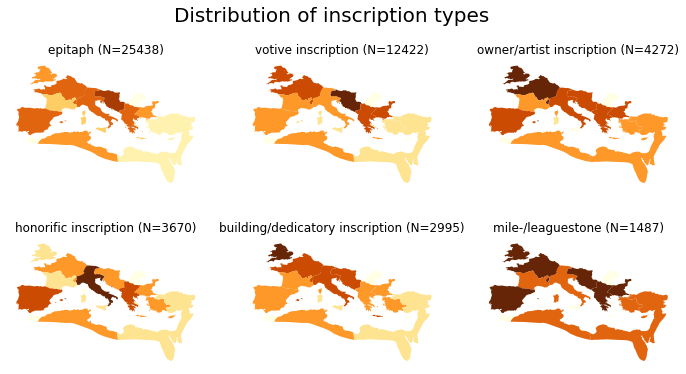

In [46]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6))

for ax, ins_type in zip(axs.ravel(), ins_types_counts[:6]):  
  provinces[ins_type[0] + "_dens"] = provinces.apply(lambda row: calculate_ins_density(row["OBJECTID"], "type_of_inscription", ins_type[0]), axis=1)
  provinces.plot(column=ins_type[0] + "_dens", cmap='YlOrBr', scheme="quantiles", k=15, legend=False, ax=ax) 
  ax.set_title(ins_type[0] + " (N=" + str(ins_type[1]) + ")")
  ax.axis("off")
fig.suptitle("Distribution of inscription types", fontsize=20)
plt.show()

In [47]:
sddk.write_file("SDAM_data/EDH/public/EDH_spatial_ins_types.png", fig, conf)

Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/EDH/public/EDH_spatial_ins_types.png"
